<h1>Creazione modello ARIMA sul totale dei dati registrati dall'ISTAT</h1>

<p>Il DataFrame utilizzato contiene i dati relativi al totale dei decessi giornalieri rigistrati dall'ISTAT dal <b>1 gennaio 2015 </b> al <b>30 aprile 2020</b>.
    </p>

In [25]:
import pandas as pd
df = pd.read_csv('../csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    1947 non-null   object
 1   Totale  1947 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.5+ KB


In [27]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1947 non-null   datetime64[ns]
 1   Totale  1947 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 30.5 KB


<h2> Creazione della serie storica </h2>

In [28]:
df=df.set_index('Data')
ts = df.Totale
ts.head()

Data
2015-01-01    2632
2015-01-02    2182
2015-01-03    2215
2015-01-04    2264
2015-01-05    2301
Name: Totale, dtype: int64

<h2>Visualizzazione della serie storica </h2>

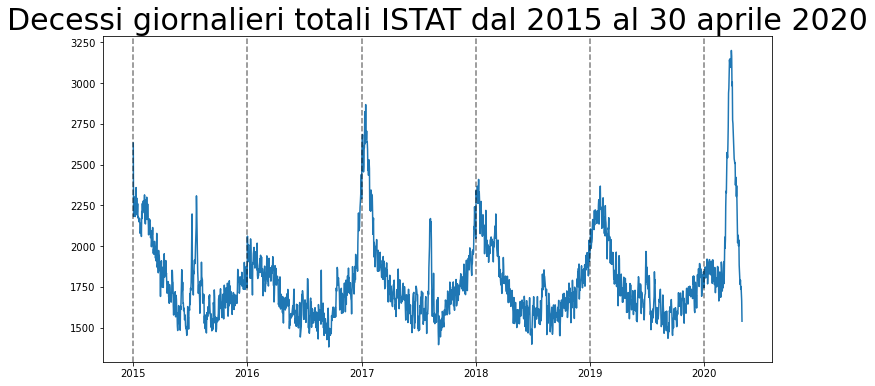

In [29]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi giornalieri totali ISTAT dal 2015 al 30 aprile 2020', size=30)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h2>Decomposizione </h2>

Attraverso la funzione `seasonal_decompose()` la serie storica viene decomposta in <b>trend</b>, <b>stagionalità</b> e <b>residui</b>. 

Tramite questo processo è possibile visionare più nel dettaglio l'andamento della serie storica esaminata, con lo scopo d'impiegare le informazioni acquisite per la creazione di un valido modello predittivo. 


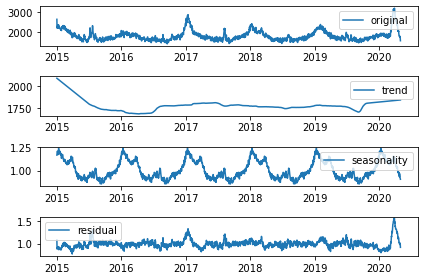

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend 
ts_seasonal = decomposition.seasonal
ts_residual = decomposition.resid
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h2> Test stazionario </h2>

La modellazione di una serie storica è possibile solo se la serie è <b>stazionaria</b>, ovvero quando le sue proprietà statistiche non variano nel tempo.

La funzione `test_stationarity()` verifica che la serie storica sia stazionaria o meno attraverso il calcolo della <b>Rolling Statistic</b> e del <b>Dickey-Fuller test</b>.

In [31]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

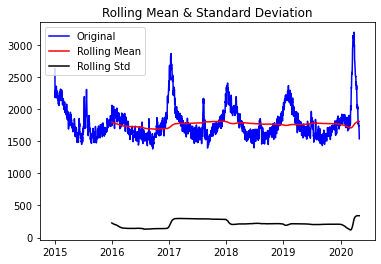

Results of Dickey-Fuller Test:
Test Statistic                -6.969065e+00
p-value                        8.760107e-10
#Lags Used                     0.000000e+00
Number of Observations Used    1.946000e+03
Critical Value (1%)           -3.433715e+00
Critical Value (5%)           -2.863026e+00
Critical Value (10%)          -2.567561e+00
dtype: float64
X is stationary


In [32]:
test_stationarity(ts)

<H2>Autocorrelazione e Autocorrelazione Parziale

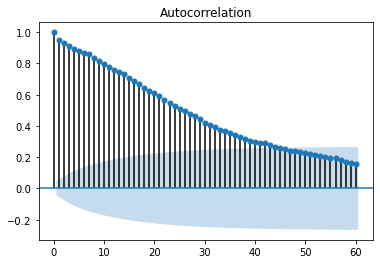

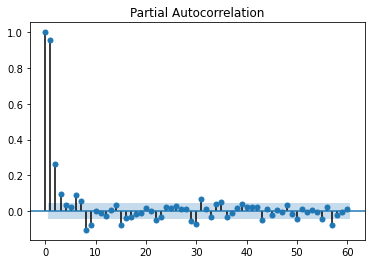

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =60)
plot_pacf(ts, lags =60)
plt.show()

<h2>Suddivisione della serie storica in train e test

Per poter costruire un modello predittivo è necessario suddividere la <b>serie storica </b> in `train` e `test`. 
<br />
La parte di `train`, che va dal <b>1 gennaio 2015</b> al <b>31 ottobre 2019</b>, sarà impiegata per l'allenamento del modello.
<br />
La parte di `test`, che va dal <b>1 novembre 2019</b> al <b>31 dicembre 2019</b>, sarà impiegata invece per testare la precisione di predizione del modello creato, andando a confrontare la predizione ottenuta con i valori originali della parte `test`.

In [34]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

# periodo dal 01-01-2015 al 31-10-2019
train = ts[:train_end]

# periodo dal 01-11-2019 al 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]

<h1>CREAZIONE DEL MODELLO

In [35]:
from statsmodels.tsa.arima_model import ARIMA
p = 1
q = 8
d = 0
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequ

                              ARMA Model Results                              
Dep. Variable:                 Totale   No. Observations:                 1765
Model:                     ARMA(1, 8)   Log Likelihood              -10015.881
Method:                       css-mle   S.D. of innovations             70.457
Date:                Wed, 18 Nov 2020   AIC                          20053.762
Time:                        14:20:35   BIC                          20113.997
Sample:                    01-01-2015   HQIC                         20076.019
                         - 10-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1790.6616     70.429     25.425      0.000    1652.624    1928.700
ar.L1.Totale     0.9881      0.004    225.555      0.000       0.980       0.997
ma.L1.Totale    -0.3494      0.025    -14.25

<h2>Verifica che i residui del modello siano stazionari

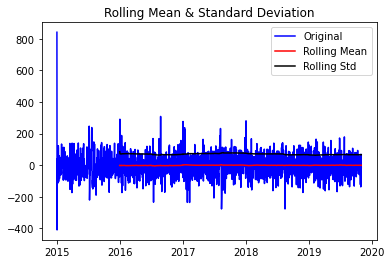

Results of Dickey-Fuller Test:
Test Statistic                  -45.111192
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


In [36]:
residuals = model_fit.resid
test_stationarity(residuals)

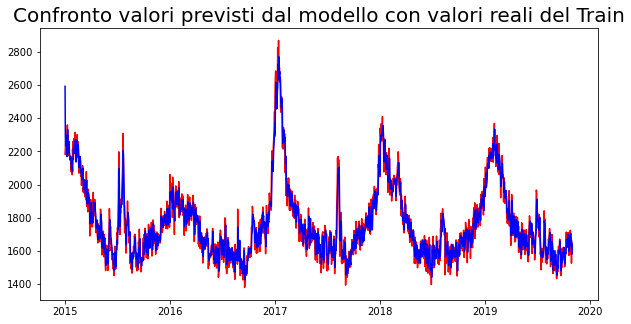

In [37]:
plt.figure(figsize=(10,5))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue')
plt.show()

<h2>Intervallo di confidenza del modello

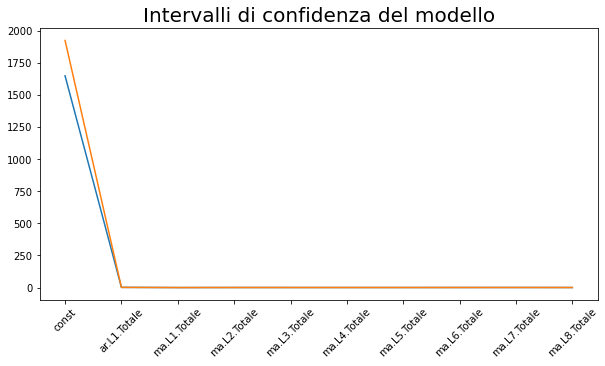

In [38]:
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h2>Predizione del modello sul test

<h4>Inizio e fine della predizione del modello

In [39]:
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-01 00:00:00


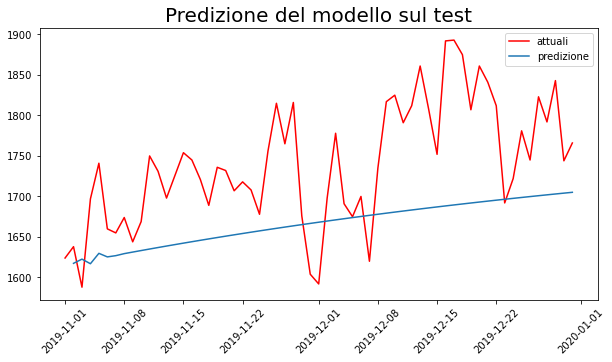

In [40]:
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(10,5))
plt.title('Predizione del modello sul test', size=20)
plt.plot(test, color='red', label='attuali')
plt.plot(predictions_test.iloc[1:], label='predizione' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

<h2>Calcolo RMSE

In [41]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.3193306805770519


<h1>Predizione totale

<h4>Inizio e fine della predizione totale

In [42]:
start = ts.index[0]
end = ts.index[-1]


print(end)
print(start)

2020-04-30 00:00:00
2015-01-01 00:00:00


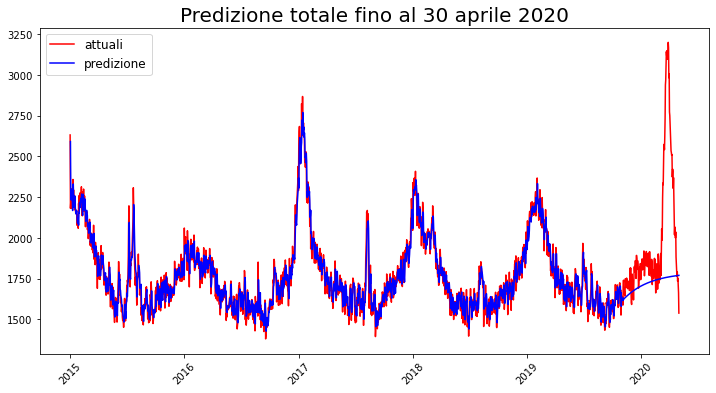

In [43]:
predictions_tot = model_fit.predict(start=start, end=end)

plt.figure(figsize=(12,6))
plt.title('Predizione totale fino al 30 aprile 2020', size=20)
plt.plot(ts, color='red', label='attuali')
plt.plot(predictions_tot.iloc[1:], label='predizione', color='blue')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

In [44]:
predictions_tot

2015-01-01    1790.661623
2015-01-02    2591.478055
2015-01-03    2292.515915
2015-01-04    2233.222115
2015-01-05    2256.919914
                 ...     
2020-04-26    1769.548586
2020-04-27    1769.799571
2020-04-28    1770.047572
2020-04-29    1770.292626
2020-04-30    1770.534766
Freq: D, Length: 1947, dtype: float64

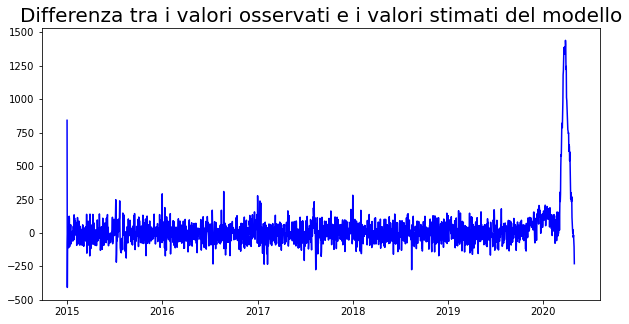

In [45]:
diff_predictions_tot = (ts - predictions_tot)

plt.figure(figsize=(10,5))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot, color='blue') 
plt.show()

In [46]:
predictions_tot.to_csv('../csv/predictions_daily_ARIMA.csv')

In [47]:
diff_predictions_tot

Data
2015-01-01    841.338377
2015-01-02   -409.478055
2015-01-03    -77.515915
2015-01-04     30.777885
2015-01-05     44.080086
                 ...    
2020-04-26    -34.548586
2020-04-27    -17.799571
2020-04-28    -68.047572
2020-04-29   -106.292626
2020-04-30   -231.534766
Length: 1947, dtype: float64

In [48]:
diff_predictions_tot['24-02-2020':].sum()

38241.594360144016